In [6]:
# import pandas and gurobi
import pandas as pd
from gurobipy import *
import numpy as np

In [27]:
# read in csv
r = pd.read_csv("/Users/zachwayne/Documents/GitHub/15093-project/2019_monthly_data/monthly_returns_2019.csv")
s = pd.read_csv("/Users/zachwayne/Documents/GitHub/15093-project/2019_monthly_data/sectors_2019.csv")
p = pd.read_csv("/Users/zachwayne/Documents/GitHub/15093-project/2019_monthly_data/monthly_prices_2019.csv")
cor = pd.read_csv("/Users/zachwayne/Documents/GitHub/15093-project/2019_monthly_data/corr_2019.csv")
cov = pd.read_csv("/Users/zachwayne/Documents/GitHub/15093-project/2019_monthly_data/cov_2019.csv")
cov = cov.drop(columns=['Unnamed: 0'])
s = s.drop(columns=['Symbol'])
p = p.drop(columns=['Date'])
r = r.drop(columns=['Date'])
cor = cor.drop(columns=['Unnamed: 0'])

In [54]:
# make model
stocks = len(s)
k = 20
T = 12
# total = array of size 12
total = np.zeros(T)
total[0] = 300000
portfolio = np.zeros((stocks, T))

In [55]:
for t in range(T-1): 
    m = Model('portfolio')

    # Add matrix variable for the stocks
    x = m.addMVar(stocks)
    z = m.addVars(stocks, vtype=GRB.BINARY, name="z")
    b = m.addVars(stocks, vtype=GRB.INTEGER, lb=0, name="x")

    # Objective is to minimize risk (squared).  This is modeled using the
    # covariance matrix, which measures the historical correlation between stocks
    portfolio_risk = x @ np.matrix(cov) @ x
    ret = np.matrix(r.iloc[t+2]) @ x
    m.setObjective(ret, GRB.MAXIMIZE)

    # Fix budget with a constraint
    m.addConstr(x.sum() == 1, 'budget')
    m.addConstrs((x[i] <= z[i] for i in range(stocks)), "w<=z")
    m.addConstrs((100*x[i] >= z[i] for i in range(stocks)), "w>=z")
    m.addConstr(quicksum(z[i] for i in range(stocks)) == k, "k")
    m.addConstr(quicksum(b[i]*p.iloc[t,i] for i in range(stocks)) <= total[t], "budget")
    m.addConstrs((b[i] >= z[i] for i in range(stocks)), "x>=fvfav")
    m.addConstrs((x[i] == (b[i]*p.iloc[t,i])/total[t] for i in range(stocks)), "w")
    m.addConstrs((quicksum(z[i]*s.iloc[i,j] for i in range(stocks)) <= 3 for j in range(len(s.columns))), "sector")
    m.Params.MIPGap = 0.01

    m.optimize()

    # print optimal x
    for v in m.getVars():
        if v.x > 0 and v.varName[0] == 'x':
            total[t+1] += v.x*p.iloc[t+1,int(v.varName.replace("x[","").replace("]",""))]
    portfolio[:,t] = np.array([v.x for v in m.getVars() if v.varName[0] == 'C'])

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1922 rows, 1431 columns and 5724 nonzeros
Model fingerprint: 0x6ea3d602
Variable types: 477 continuous, 954 integer (477 binary)
Coefficient statistics:
  Matrix range     [2e-05, 3e+03]
  Objective range  [8e-05, 3e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+05]
Presolve removed 955 rows and 477 columns
Presolve time: 0.01s
Presolved: 967 rows, 954 columns, 3339 nonzeros
Variable types: 0 continuous, 954 integer (477 binary)

Root relaxation: objective 2.972756e-01, 579 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.29728    0    1          -    0.29728      -     -    0s
H    0     0                   

In [56]:
#loop through total and print out the total value of the portfolio at each time step
for i in range(len(total)):
    if i == 0:
        print("Initial value: " + str(total[i]))
    else:
        print("Total value of portfolio at the end of month " + str(i) + ": " + str(total[i]))

Initial value: 300000.0
Total value of portfolio at the end of month 1: 389176.3015174866
Total value of portfolio at the end of month 2: 458017.8966636657
Total value of portfolio at the end of month 3: 662654.990483284
Total value of portfolio at the end of month 4: 946739.7603588103
Total value of portfolio at the end of month 5: 1247638.2204303741
Total value of portfolio at the end of month 6: 1829089.8448200203
Total value of portfolio at the end of month 7: 2241539.478580475
Total value of portfolio at the end of month 8: 2815655.663793564
Total value of portfolio at the end of month 9: 3801165.6438827515
Total value of portfolio at the end of month 10: 5398453.091891289
Total value of portfolio at the end of month 11: 7521100.533203125


Text(0, 0.5, 'Percentage of portfolio')

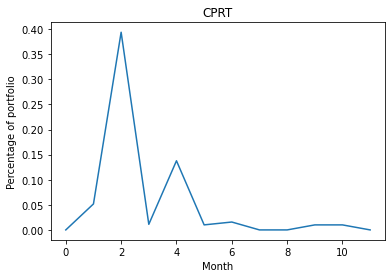

In [127]:
import matplotlib.pyplot as plt
stockPlot = 124
plt.plot(portfolio[stockPlot,:])
# TITLE  = stock name
plt.title(p.columns[stockPlot])
plt.xlabel("Month")
plt.ylabel("Percentage of portfolio")